In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from autoemulate.compare import AutoEmulate
from sklearn.metrics import r2_score

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.flow_functions import FlowProblem

import json

show_progress = False if os.getenv("JUPYTER_BOOK_BUILD", "false").lower() == "true" else True

In [2]:
# Load the simulation input parameters and summary statistics

n_samples = 256 ## compare with separate notebook 32768

sim_path = f'./outputs/simulations/output_{n_samples}_samples/'

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(sim_path, f'input_samples_{n_samples}.csv'))

# Load the boolean mask for failed simulations
with open(os.path.join(sim_path, 'bool_indices.json'), 'r') as f:
    bool_indices = json.load(f)

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(sim_path, f'simulations_summary.csv'))

In [3]:
# Get column names for parameters up to 'T'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('T') + 1])

input_params[parameter_names]

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas,T
0,324.140512,0.429410,970.557289,2.593650,5.759509,141.391649,5.535208,3.645771,0.302181,0.614511,13.751520,0.074688,1.310537,3.983934,10.192377,0.040153,458.957450
1,213.211374,0.168363,1134.582900,3.092750,11.457833,81.051107,6.337772,5.927350,0.476733,0.449234,6.030600,0.032403,0.538215,2.789425,7.998957,0.014420,1177.644680
2,128.027561,0.373035,664.791603,1.807716,9.775524,110.934879,3.831676,4.690519,0.657067,0.244713,9.303856,0.023797,1.070499,3.257826,7.055576,0.027896,771.390037
3,287.120769,0.262023,1448.888220,3.761496,8.444797,167.239972,7.529157,2.905174,0.338195,0.522401,10.791995,0.054236,0.830979,2.014983,14.871574,0.027224,590.140139
4,261.317508,0.322630,1342.111306,4.190009,7.184780,154.969280,3.238999,4.237066,0.583734,0.372392,7.797148,0.048891,1.195902,2.575591,12.781972,0.020054,650.410479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,261.774613,0.174077,705.581321,2.006299,11.007814,104.685589,6.325800,4.760196,0.446670,0.336462,9.263029,0.055210,1.052124,3.960575,5.865984,0.034163,449.727307
252,288.544670,0.403509,950.787981,1.667142,9.191806,84.207915,4.662083,2.383533,0.255271,0.572178,12.460819,0.045991,0.921056,3.395567,6.783901,0.028497,397.525106
253,128.514364,0.217487,1154.360255,3.995832,7.991282,161.210954,6.859133,4.186658,0.519131,0.406987,7.678974,0.030102,1.177695,1.830367,13.965423,0.026910,1028.383294
254,212.724971,0.309885,649.404626,2.359235,6.210696,197.473244,3.228266,5.440255,0.558797,0.258626,6.908484,0.038819,0.713764,4.174409,11.165976,0.039694,920.932736


In [4]:
# Drop all the rows from input_params that correspond to entries in bool_indices
input_params = input_params.drop(bool_indices)

In [5]:
Y = summary_stats['p_ao_mean'].values

In [6]:
em = AutoEmulate()
em.setup(X = input_params[parameter_names], 
         y = Y, 
         models = ['gp'], ## Stick to gp
         n_jobs=-1)

,Values
Simulation input shape (X),"(255, 17)"
Simulation output shape (y),"(255,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),False


In [7]:
best_model = em.compare()

Cross-validating:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
em.summarise_cv() ##compare with larger sample sets e.g 4096, 8192, 16384.

,preprocessing,model,short,fold,rmse,r2
0,None,GaussianProcess,gp,3,47.107635,0.446960
1,None,GaussianProcess,gp,4,41.837406,0.390174
2,None,GaussianProcess,gp,1,46.574276,0.245290
3,None,GaussianProcess,gp,2,57.627928,0.083080
4,None,GaussianProcess,gp,0,37.064524,0.009909


In [13]:
em.summarise_cv()['r2'].mean()

0.23508265175621176

In [ ]:
gp = em.get_model("GaussianProcess")
em.evaluate(gp) # make a table w no of simulations and rows for each showing r2 values. 

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,None,63.5908,0.3012


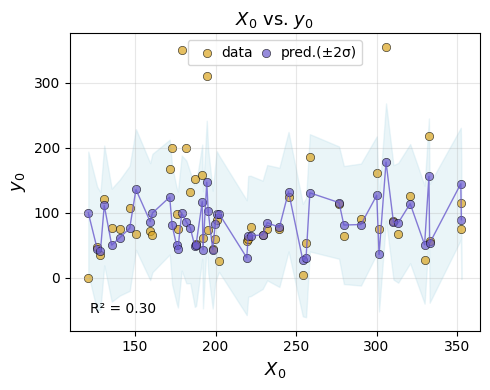

In [10]:
em.plot_eval(gp)

In [11]:
best_emulator = em.refit(gp)